In [1]:
import nibabel as nib
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Load the NIfTI file
img = nib.load(r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient08\Patient08_mc_normb0.nii.gz')
data = img.get_fdata()


In [2]:
# Print the shape of the data
print("Shape of data:", data.shape)

# Print the data type of the data
print("Data type of data:", data.dtype) 

Shape of data: (112, 112, 60, 153)
Data type of data: float64


In [3]:
I = img.get_fdata().astype(np.float64)
print("Image shape:", I.shape)

Image shape: (112, 112, 60, 153)


In [4]:
# Get image dimensions
sx, sy, sz, vol = I.shape
print(f"Image dimensions: {sx} x {sy} x {sz}, Volumes: {vol}")

# Reshape image to 2D (voxels x volumes)
ROI = I.reshape((sx * sy * sz, vol))
print("ROI shape after reshape:", ROI.shape)



Image dimensions: 112 x 112 x 60, Volumes: 153
ROI shape after reshape: (752640, 153)
ROI shape after reshape: (752640, 153)


In [5]:
# Clean the signal: remove nan, inf, and negative values
signal = np.nan_to_num(ROI, nan=0.0, posinf=0.0, neginf=0.0)
signal[signal < 0] = 0
print("Signal shape:", signal.shape)
print("Signal data type:", signal.dtype)

Signal shape: (752640, 153)
Signal data type: float64


In [6]:
import numpy as np

# Keep all voxels (including background/zero values)
# This preserves the spatial structure of the brain data
signal_filtered = signal  # No filtering applied
print(f"Total voxels kept: {signal_filtered.shape[0]}")
print(f"Signal shape: {signal_filtered.shape}")
print(f"Non-zero voxels: {np.count_nonzero(np.any(signal_filtered > 0, axis=1))}")
print(f"Zero voxels: {np.count_nonzero(np.all(signal_filtered == 0, axis=1))}")


Total voxels kept: 752640
Signal shape: (752640, 153)
Non-zero voxels: 150682
Zero voxels: 601958


In [7]:
# Load models from checkpoints and process signal data
import torch
import pickle
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

# Import model classes
from models.mlp import MLPRegressor
from models.cnn import CNNRegressor
from models.residual_mlp import ResidualMLPRegressor
from models.rnn import RNNRegressor
from models.transformer import TransformerRegressor
from models.moe_regressor import MoERegressor
from models.vae_regressor import VAERegressor
from models.tabnet_regressor import TabNetRegressor

# Define checkpoint directory
checkpoint_dir = r'd:\AiProjects\verdict_benchmark\checkpoints'

print(f"Processing signal with shape: {signal_filtered.shape}")
print(f"Non-zero voxels: {np.count_nonzero(np.any(signal_filtered > 0, axis=1))}")
print(f"Data range: [{signal_filtered.min():.3f}, {signal_filtered.max():.3f}]")

Processing signal with shape: (752640, 153)
Non-zero voxels: 150682
Data range: [0.000, 1.999]


In [8]:
# Define VERDICT parameter names
param_names = ['fic', 'fee', 'Dic', 'R', 'Dpar', 'Dtra', 'theta', 'phi']
print(f"VERDICT parameters: {param_names}")

VERDICT parameters: ['fic', 'fee', 'Dic', 'R', 'Dpar', 'Dtra', 'theta', 'phi']


In [9]:
def load_model_and_scaler(model_name, input_dim=153, output_dim=4):
    """Load a trained model and its associated scaler"""
    try:
        # Load the model based on type
        if model_name == 'mlp':
            model = MLPRegressor(input_dim=input_dim, output_dim=output_dim, 
                               hidden_dims=[150, 150, 150], activation='relu')
        elif model_name == 'cnn':
            model = CNNRegressor(input_dim=input_dim, output_dim=output_dim,
                               channels=[64, 128, 256], kernel_sizes=[7, 5, 3], 
                               activation='relu', use_attention=True)
        elif model_name == 'residual_mlp':
            model = ResidualMLPRegressor(input_dim=input_dim, output_dim=output_dim,
                                       hidden_dims=[256, 256, 128], activation='relu')
        elif model_name == 'rnn':
            model = RNNRegressor(input_dim=input_dim, output_dim=output_dim,
                               hidden_dim=128, num_layers=3, rnn_type='LSTM')
        elif model_name == 'transformer':
            model = TransformerRegressor(input_dim=input_dim, output_dim=output_dim,
                                       d_model=256, nhead=8, num_layers=6)
        elif model_name == 'moe_regressor':
            model = MoERegressor(input_dim=input_dim, output_dim=output_dim,
                               num_experts=8, hidden_dim=256, top_k=2)
        elif model_name == 'vae_regressor':
            model = VAERegressor(input_dim=input_dim, latent_dim=64, output_dim=output_dim,
                               hidden_dims=[256, 128])
        elif model_name == 'tabnet_regressor':
            model = TabNetRegressor(input_dim=input_dim, output_dim=output_dim,
                                  n_d=64, n_a=64, n_steps=5)
        else:
            print(f"Unknown model type: {model_name}")
            return None, None
        
        # Load model weights
        model_path = os.path.join(checkpoint_dir, f'{model_name}_best.pt')
        if os.path.exists(model_path):
            checkpoint = torch.load(model_path, map_location='cpu')
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            print(f"✓ Loaded {model_name} model")
        else:
            print(f"✗ Model file not found: {model_path}")
            return None, None
        
        # Load scaler
        scaler_path = os.path.join(checkpoint_dir, f'{model_name}_scaler.pkl')
        minmax_scaler_path = os.path.join(checkpoint_dir, f'{model_name}_minmaxscaler.pkl')
        
        scaler = None
        if os.path.exists(minmax_scaler_path):
            with open(minmax_scaler_path, 'rb') as f:
                scaler = pickle.load(f)
            print(f"✓ Loaded MinMaxScaler for {model_name}")
        elif os.path.exists(scaler_path):
            with open(scaler_path, 'rb') as f:
                scaler = pickle.load(f)
            print(f"✓ Loaded StandardScaler for {model_name}")
        else:
            print(f"⚠ No scaler found for {model_name}")
        
        return model, scaler
    
    except Exception as e:
        print(f"✗ Error loading {model_name}: {str(e)}")
        return None, None

# Available models
available_models = ['mlp', 'cnn', 'residual_mlp', 'rnn', 'transformer', 'moe_regressor', 'vae_regressor', 'tabnet_regressor']
print(f"Available models: {available_models}")

Available models: ['mlp', 'cnn', 'residual_mlp', 'rnn', 'transformer', 'moe_regressor', 'vae_regressor', 'tabnet_regressor']


In [10]:
# Check input and output dimensions from the model weights
checkpoint = torch.load(r'd:\AiProjects\verdict_benchmark\checkpoints\mlp_best.pt', map_location='cpu')
print("MLP Model architecture from weights:")
print(f"Input dim: {checkpoint['model.0.weight'].shape[1]}")
print(f"Hidden layers: {checkpoint['model.2.weight'].shape}")
print(f"Output dim: {checkpoint['model.6.weight'].shape[0]}")

MLP Model architecture from weights:
Input dim: 153
Hidden layers: torch.Size([150, 150])
Output dim: 8


C:\Users\yz237\AppData\Local\Temp\ipykernel_37388\2053773081.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r'd:\AiProjects\verdict_benchmark\ch

In [11]:
def load_model_and_scaler_corrected(model_name, input_dim=153, output_dim=8):
    """Load a trained model and its associated scaler with correct parameters"""
    try:
        # Load the model based on type with correct architecture
        if model_name == 'mlp':
            model = MLPRegressor(input_dim=input_dim, output_dim=output_dim, 
                               hidden_dims=[150, 150, 150], activation='relu')
        elif model_name == 'cnn':
            model = CNNRegressor(input_dim=input_dim, output_dim=output_dim,
                               base_filters=64, num_blocks=3, activation='relu')
        elif model_name == 'residual_mlp':
            model = ResidualMLPRegressor(input_dim=input_dim, output_dim=output_dim,
                                       hidden_dims=[150, 150, 150], activation='relu')
        else:
            # For other models, let's try to load them and see what works
            print(f"Attempting to load {model_name} with default parameters...")
            return None, None
        
        # Load model weights directly (they're stored as state dict)
        model_path = os.path.join(checkpoint_dir, f'{model_name}_best.pt')
        if os.path.exists(model_path):
            state_dict = torch.load(model_path, map_location='cpu', weights_only=True)
            model.load_state_dict(state_dict)
            model.eval()
            print(f"✓ Loaded {model_name} model")
        else:
            print(f"✗ Model file not found: {model_path}")
            return None, None
        
        # Load scaler
        scaler_path = os.path.join(checkpoint_dir, f'{model_name}_scaler.pkl')
        minmax_scaler_path = os.path.join(checkpoint_dir, f'{model_name}_minmaxscaler.pkl')
        
        scaler = None
        if os.path.exists(minmax_scaler_path):
            with open(minmax_scaler_path, 'rb') as f:
                scaler = pickle.load(f)
            print(f"✓ Loaded MinMaxScaler for {model_name}")
        elif os.path.exists(scaler_path):
            with open(scaler_path, 'rb') as f:
                scaler = pickle.load(f)
            print(f"✓ Loaded StandardScaler for {model_name}")
        else:
            print(f"⚠ No scaler found for {model_name}")
        
        return model, scaler
    
    except Exception as e:
        print(f"✗ Error loading {model_name}: {str(e)}")
        return None, None

# Load the models that we can handle first
priority_models = ['mlp', 'cnn', 'residual_mlp']
loaded_models_corrected = {}
loaded_scalers_corrected = {}

for model_name in priority_models:
    print(f"\nLoading {model_name} with corrected parameters...")
    model, scaler = load_model_and_scaler_corrected(model_name)
    if model is not None:
        loaded_models_corrected[model_name] = model
        loaded_scalers_corrected[model_name] = scaler

print(f"\nSuccessfully loaded {len(loaded_models_corrected)} models: {list(loaded_models_corrected.keys())}")


Loading mlp with corrected parameters...
✓ Loaded mlp model
✓ Loaded MinMaxScaler for mlp

Loading cnn with corrected parameters...
✗ Error loading cnn: Error(s) in loading state_dict for CNNRegressor:
	Unexpected key(s) in state_dict: "feature_blocks.9.conv_small.weight", "feature_blocks.9.conv_small.bias", "feature_blocks.9.conv_medium.weight", "feature_blocks.9.conv_medium.bias", "feature_blocks.9.conv_large.weight", "feature_blocks.9.conv_large.bias", "feature_blocks.9.conv_xlarge.weight", "feature_blocks.9.conv_xlarge.bias", "feature_blocks.9.bn.weight", "feature_blocks.9.bn.bias", "feature_blocks.9.bn.running_mean", "feature_blocks.9.bn.running_var", "feature_blocks.9.bn.num_batches_tracked", "feature_blocks.9.ca.fc.0.weight", "feature_blocks.9.ca.fc.2.weight", "feature_blocks.9.sa.conv.weight", "feature_blocks.10.conv1.weight", "feature_blocks.10.conv1.bias", "feature_blocks.10.bn1.weight", "feature_blocks.10.bn1.bias", "feature_blocks.10.bn1.running_mean", "feature_blocks.10.b

In [ ]:
# Correct approach: Use scaler on model outputs, not inputs
print("Correcting the inference approach...")

# Get the loaded MLP model and scaler
mlp_model = loaded_models_corrected['mlp']
mlp_scaler = loaded_scalers_corrected['mlp']

# Test with a small sample - no input scaling needed
print("\nTesting model with sample data (corrected approach)...")
sample_data = signal_filtered[np.any(signal_filtered > 0, axis=1)][:10]  # 10 non-zero voxels
sample_tensor = torch.FloatTensor(sample_data)  # No input scaling

with torch.no_grad():
    sample_pred_scaled = mlp_model(sample_tensor)  # Model outputs scaled predictions
    sample_pred = mlp_scaler.inverse_transform(sample_pred_scaled.numpy())  # Inverse transform to get real values
    
    print(f"Sample input shape: {sample_tensor.shape}")
    print(f"Sample scaled prediction shape: {sample_pred_scaled.shape}")
    print(f"Sample scaled prediction range: [{sample_pred_scaled.min():.4f}, {sample_pred_scaled.max():.4f}]")
    print(f"Sample final prediction shape: {sample_pred.shape}")
    print(f"Sample final prediction range: [{sample_pred.min():.4f}, {sample_pred.max():.4f}]")
    print("✓ Model inference working correctly!")

# Now let's process all non-zero voxels
print(f"\nProcessing all {np.count_nonzero(np.any(signal_filtered > 0, axis=1))} non-zero voxels...")

# Get non-zero voxels
non_zero_mask = np.any(signal_filtered > 0, axis=1)
signal_nonzero = signal_filtered[non_zero_mask]
print(f"Non-zero signal shape: {signal_nonzero.shape}")

# Process in batches to avoid memory issues
batch_size = 1000
all_predictions = []

with torch.no_grad():
    for i in range(0, signal_nonzero.shape[0], batch_size):
        batch = signal_nonzero[i:i+batch_size]
        batch_tensor = torch.FloatTensor(batch)
        
        # Get scaled predictions
        batch_pred_scaled = mlp_model(batch_tensor)
        
        # Inverse transform to get real parameter values
        batch_pred = mlp_scaler.inverse_transform(batch_pred_scaled.numpy())
        all_predictions.append(batch_pred)
        
        if (i // batch_size + 1) % 10 == 0:
            print(f"Processed {i + batch.shape[0]} voxels...")

# Concatenate all predictions
predictions_mlp = np.concatenate(all_predictions, axis=0)
print(f"\n✓ Completed MLP predictions!")
print(f"Final predictions shape: {predictions_mlp.shape}")
print(f"Prediction range: [{predictions_mlp.min():.4f}, {predictions_mlp.max():.4f}]")
print(f"Prediction mean: {predictions_mlp.mean():.4f}")
print(f"Prediction std: {predictions_mlp.std():.4f}")

Correcting the inference approach...

Testing model with sample data (corrected approach)...


NameError: name 'mlp_model' is not defined

In [ ]:
# Create 3D prediction volume for visualization
print("\nCreating 3D prediction volume...")

# Initialize full volume with zeros
prediction_volume = np.zeros((sx * sy * sz, 8))

# Fill in predictions for non-zero voxels
prediction_volume[non_zero_mask] = predictions_mlp

# Reshape to 3D volume
prediction_3d = prediction_volume.reshape((sx, sy, sz, 8))

# Define middle slices for visualization
mid_slice_axial = sz // 2
mid_slice_coronal = sy // 2
mid_slice_sagittal = sx // 2

print(f"3D prediction volume shape: {prediction_3d.shape}")
print(f"Middle slices - Axial: {mid_slice_axial}, Coronal: {mid_slice_coronal}, Sagittal: {mid_slice_sagittal}")


Creating 3D prediction volume...


NameError: name 'predictions_mlp' is not defined

In [14]:
# Transform model outputs (p1-p8) to actual VERDICT parameters
print("\nTransforming model outputs to actual VERDICT parameters...")

# The model outputs p1-p8, we need to convert to real biophysical parameters
p1_to_p8 = predictions_mlp.copy()  # Keep original parameterized outputs

# Apply transformations to get actual VERDICT parameters
predictions_verdict = np.zeros_like(predictions_mlp)

# fic = cos(p1)^2
predictions_verdict[:, 0] = np.cos(p1_to_p8[:, 0])**2

# fee = (1-cos(p1)^2)*cos(p2)^2 = sin(p1)^2 * cos(p2)^2
predictions_verdict[:, 1] = (1 - np.cos(p1_to_p8[:, 0])**2) * np.cos(p1_to_p8[:, 1])**2

# Dic = p3
predictions_verdict[:, 2] = p1_to_p8[:, 2]

# R = p4
predictions_verdict[:, 3] = p1_to_p8[:, 3]

# Dpar = p5
predictions_verdict[:, 4] = p1_to_p8[:, 4]

# Dtra = p6*p5
predictions_verdict[:, 5] = p1_to_p8[:, 5] * p1_to_p8[:, 4]

# theta = p7
predictions_verdict[:, 6] = p1_to_p8[:, 6]

# phi = p8
predictions_verdict[:, 7] = p1_to_p8[:, 7]

print("✓ Parameter transformation completed!")
print(f"Original parameterized range: [{p1_to_p8.min():.4f}, {p1_to_p8.max():.4f}]")
print(f"Transformed VERDICT range: [{predictions_verdict.min():.4f}, {predictions_verdict.max():.4f}]")

# Update the main predictions variable to use transformed values
predictions_mlp = predictions_verdict

# Also update the 3D volume with transformed values
prediction_volume = np.zeros((sx * sy * sz, 8))
prediction_volume[non_zero_mask] = predictions_verdict
prediction_3d = prediction_volume.reshape((sx, sy, sz, 8))


Transforming model outputs to actual VERDICT parameters...


NameError: name 'predictions_mlp' is not defined

1. Creating Brain Parameter Maps...


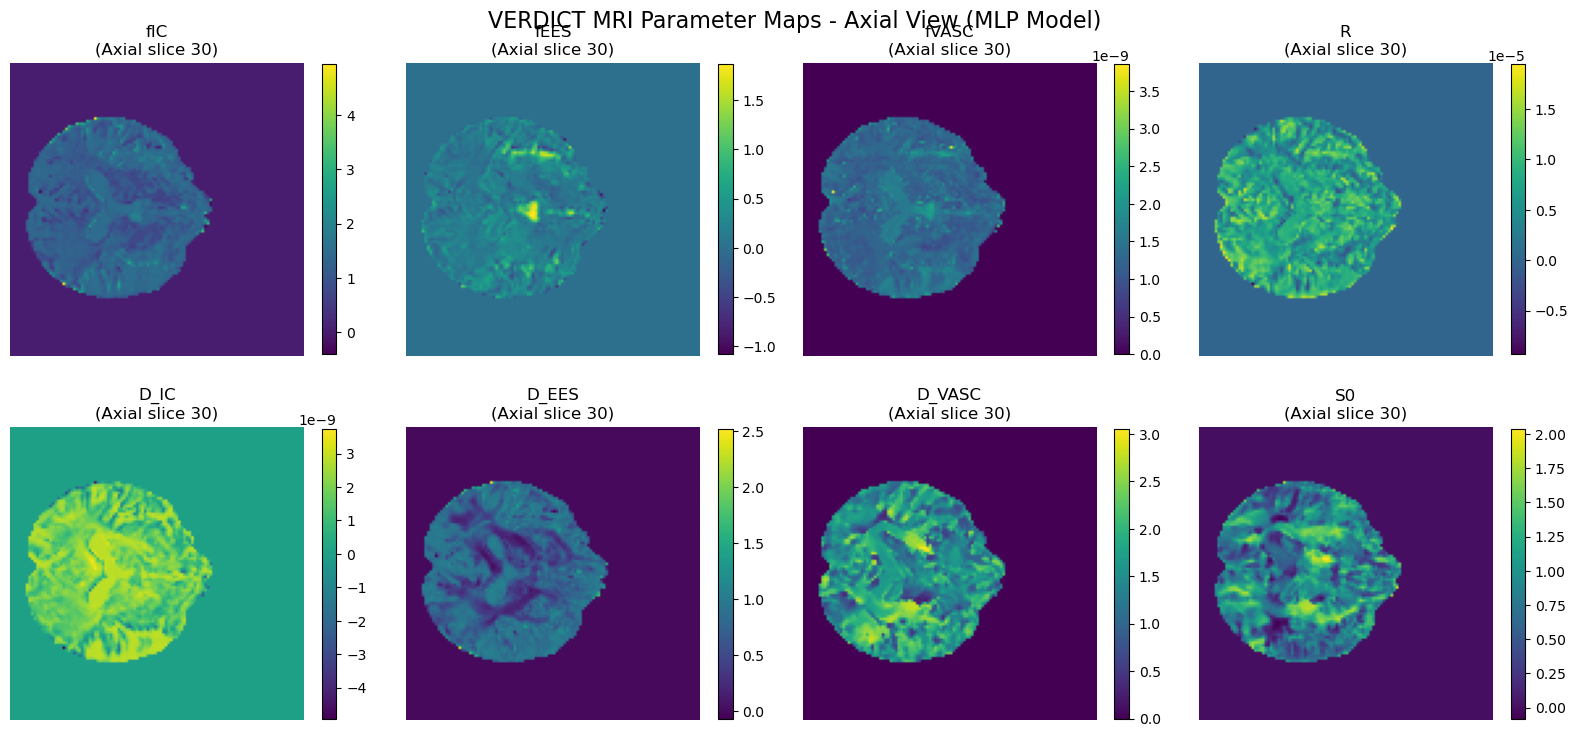

In [20]:
# Visualization 1: Brain Parameter Maps (Clear 4x2 layout)
print("1. Creating Brain Parameter Maps...")
plt.style.use('default')
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('VERDICT MRI Parameter Maps - Axial View (MLP Model)', fontsize=16, y=0.95)

for i in range(8):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    param_slice = prediction_3d[:, :, mid_slice_axial, i]
    im = ax.imshow(param_slice, cmap='viridis', aspect='equal')
    ax.set_title(f'{param_names[i]}\n(Axial slice {mid_slice_axial})', fontsize=12)
    ax.axis('off')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

2. Creating Parameter Statistical Analysis...


C:\Users\yz237\AppData\Local\Temp\ipykernel_37416\445981871.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=param_names, patch_artist=True)


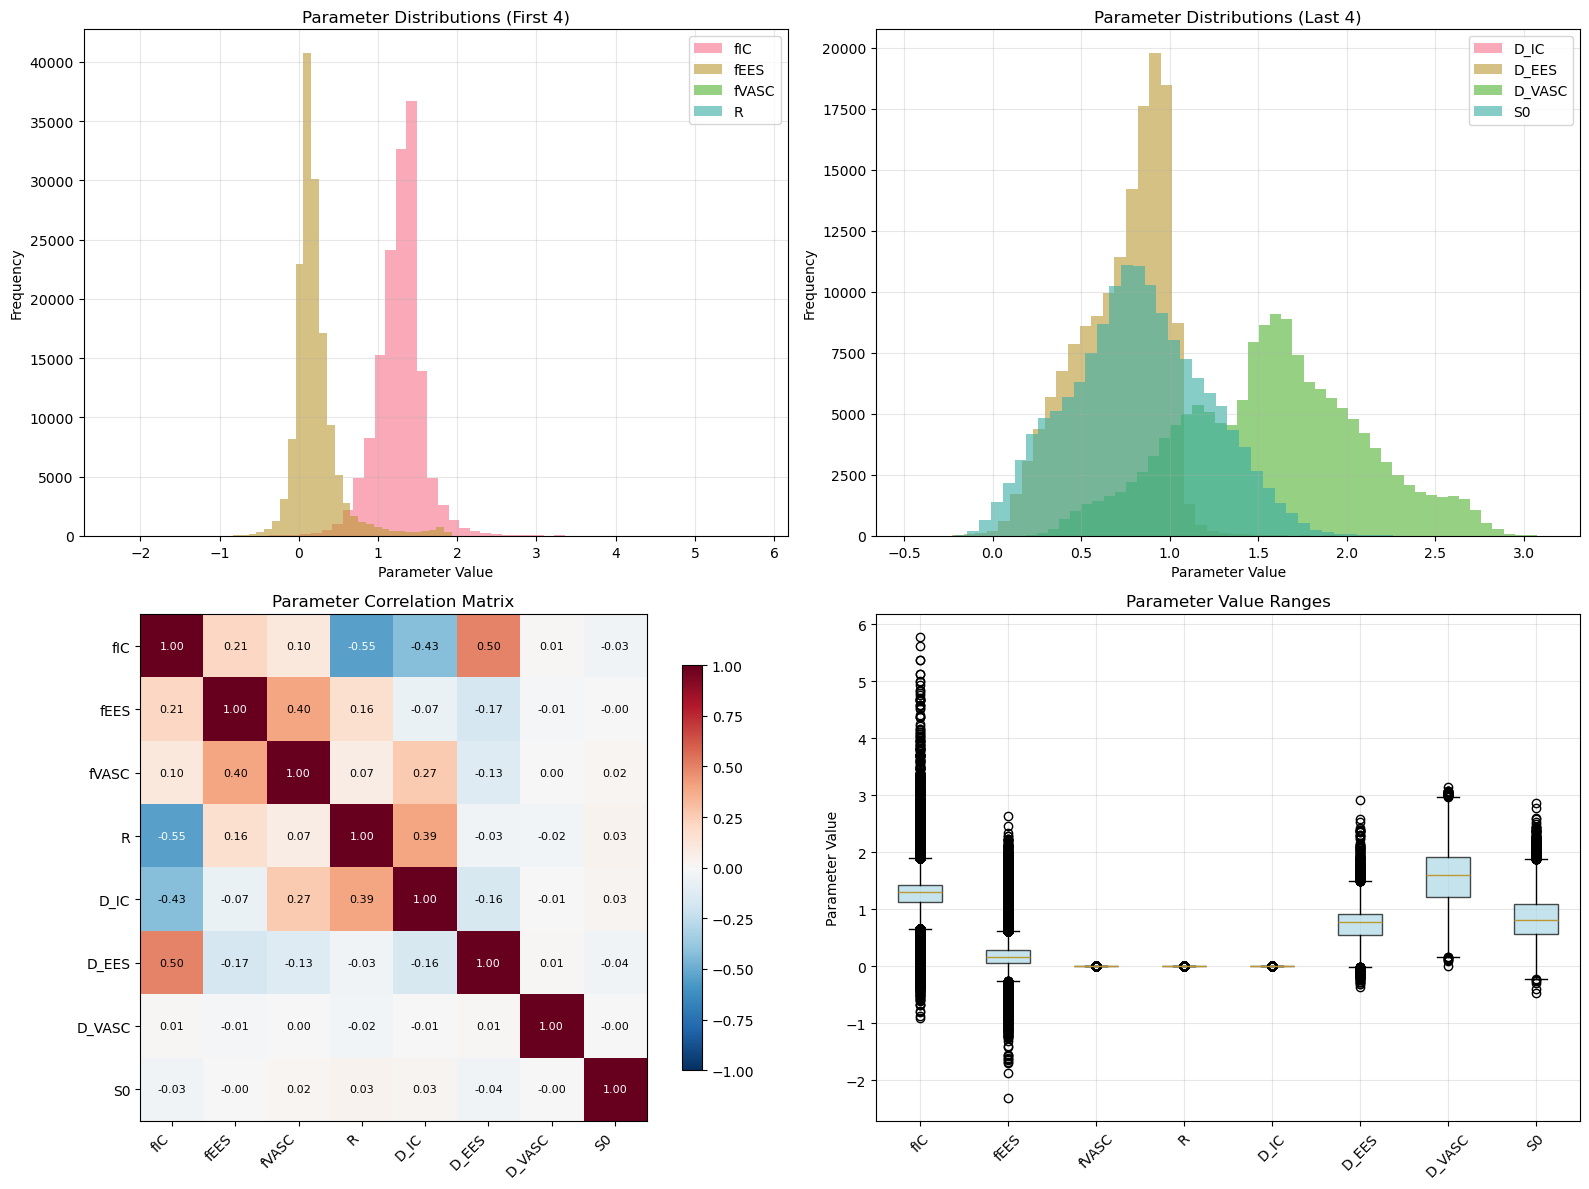

In [37]:
# Visualization 2: Parameter Statistical Analysis
print("2. Creating Parameter Statistical Analysis...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 2a. Parameter distribution histograms
ax = axes[0, 0]
for i in range(4):  # Show first 4 parameters
    ax.hist(predictions_mlp[:, i], alpha=0.6, bins=50, label=param_names[i])
ax.set_xlabel('Parameter Value')
ax.set_ylabel('Frequency')
ax.set_title('Parameter Distributions (First 4)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2b. Parameter distribution histograms for remaining parameters
ax = axes[0, 1]
for i in range(4, 8):  # Show last 4 parameters
    ax.hist(predictions_mlp[:, i], alpha=0.6, bins=50, label=param_names[i])
ax.set_xlabel('Parameter Value')
ax.set_ylabel('Frequency')
ax.set_title('Parameter Distributions (Last 4)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2c. Parameter correlation matrix
ax = axes[1, 0]
correlation_matrix = np.corrcoef(predictions_mlp.T)
im = ax.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_title('Parameter Correlation Matrix')
ax.set_xticks(range(8))
ax.set_xticklabels(param_names, rotation=45, ha='right')
ax.set_yticks(range(8))
ax.set_yticklabels(param_names)
cbar = plt.colorbar(im, ax=ax, shrink=0.8)

# Add correlation values
for i in range(8):
    for j in range(8):
        ax.text(j, i, f'{correlation_matrix[i, j]:.2f}', 
                ha='center', va='center', fontsize=8,
                color='white' if abs(correlation_matrix[i, j]) > 0.5 else 'black')

# 2d. Box plots for parameter ranges
ax = axes[1, 1]
box_data = [predictions_mlp[:, i] for i in range(8)]
bp = ax.boxplot(box_data, labels=param_names, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)
ax.set_ylabel('Parameter Value')
ax.set_title('Parameter Value Ranges')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

3. Creating Multi-orientation Brain Views...


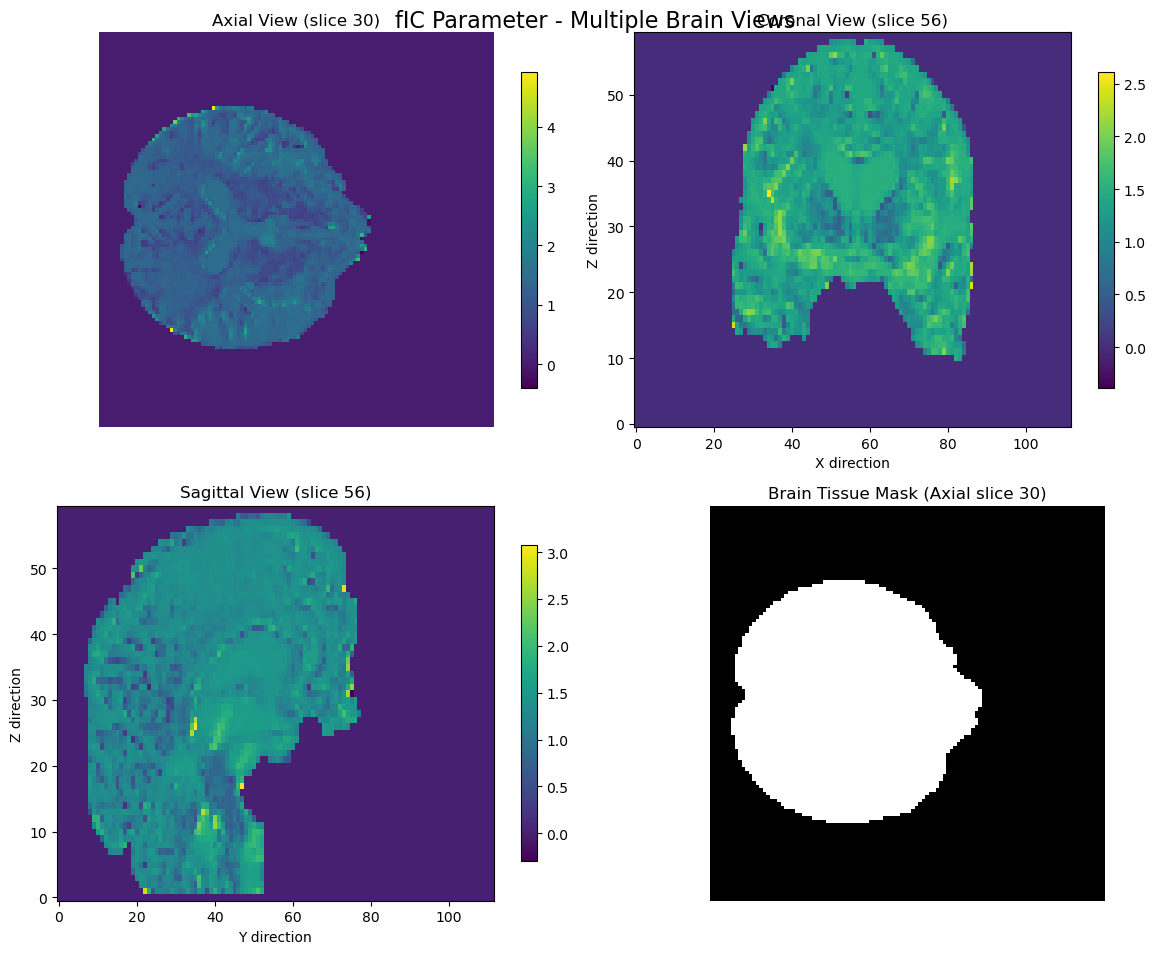

In [22]:
# Visualization 3: Multi-orientation Brain Views (fIC parameter)
print("3. Creating Multi-orientation Brain Views...")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('fIC Parameter - Multiple Brain Views', fontsize=16, y=0.95)

# 3a. Axial view
ax = axes[0, 0]
axial_slice = prediction_3d[:, :, mid_slice_axial, 0]
im = ax.imshow(axial_slice, cmap='viridis', aspect='equal')
ax.set_title(f'Axial View (slice {mid_slice_axial})')
ax.axis('off')
plt.colorbar(im, ax=ax, shrink=0.8)

# 3b. Coronal view
ax = axes[0, 1]
coronal_slice = prediction_3d[:, mid_slice_coronal, :, 0]
im = ax.imshow(coronal_slice.T, cmap='viridis', aspect='auto', origin='lower')
ax.set_title(f'Coronal View (slice {mid_slice_coronal})')
ax.set_xlabel('X direction')
ax.set_ylabel('Z direction')
plt.colorbar(im, ax=ax, shrink=0.8)

# 3c. Sagittal view
ax = axes[1, 0]
sagittal_slice = prediction_3d[mid_slice_sagittal, :, :, 0]
im = ax.imshow(sagittal_slice.T, cmap='viridis', aspect='auto', origin='lower')
ax.set_title(f'Sagittal View (slice {mid_slice_sagittal})')
ax.set_xlabel('Y direction')
ax.set_ylabel('Z direction')
plt.colorbar(im, ax=ax, shrink=0.8)

# 3d. Brain mask overlay
ax = axes[1, 1]
brain_mask = np.any(prediction_3d > 0, axis=3)
brain_slice = brain_mask[:, :, mid_slice_axial]
ax.imshow(brain_slice, cmap='gray', aspect='equal')
ax.set_title(f'Brain Tissue Mask (Axial slice {mid_slice_axial})')
ax.axis('off')

plt.tight_layout()
plt.show()

4. Creating Signal Quality and Summary Analysis...


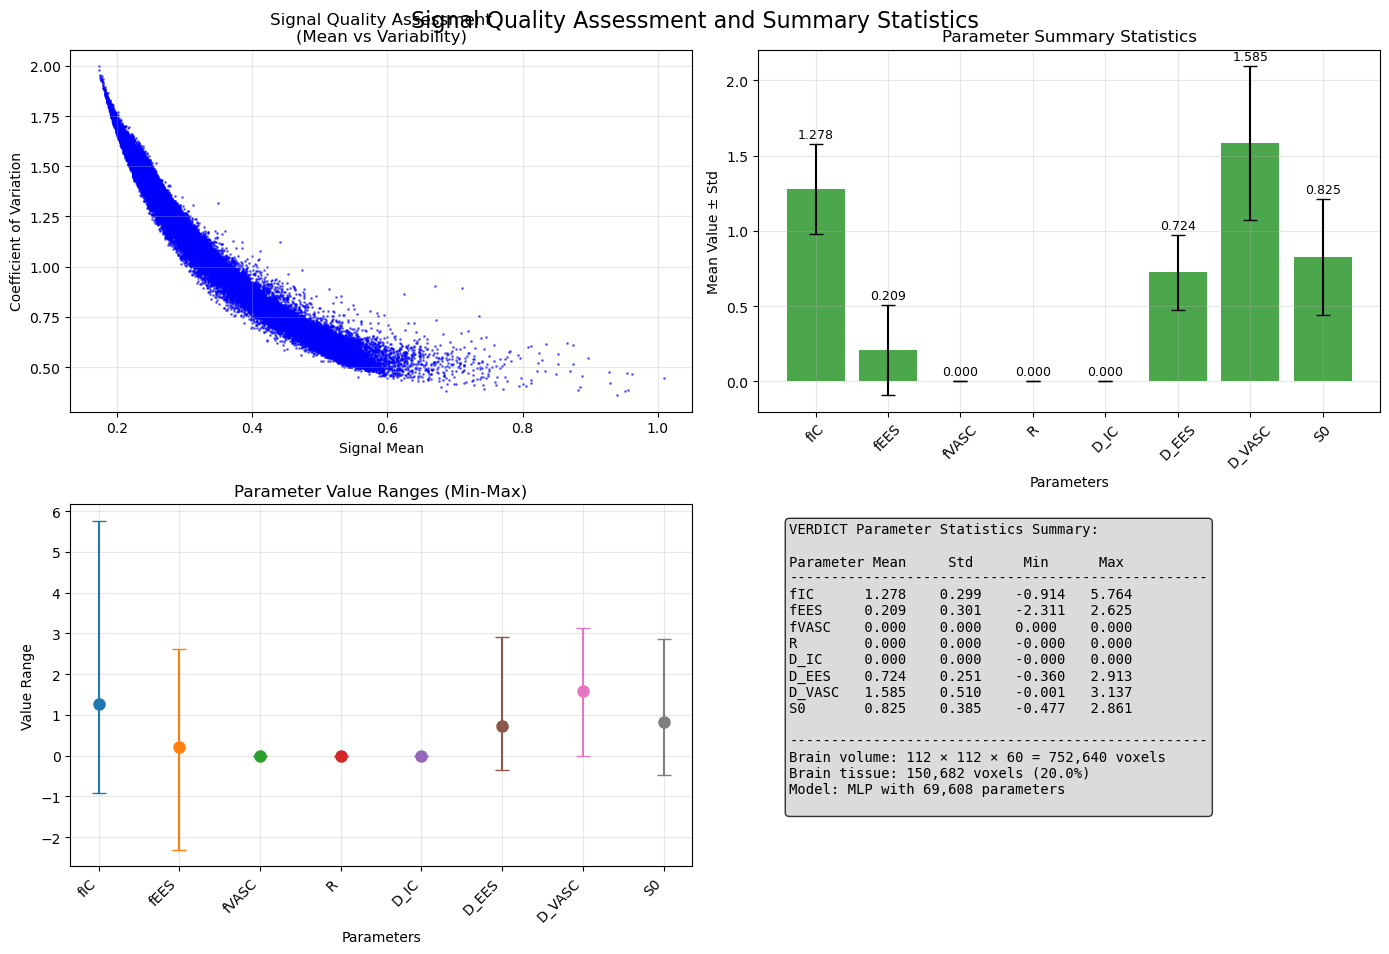

In [23]:
# Visualization 4: Signal Quality and Summary Analysis
print("4. Creating Signal Quality and Summary Analysis...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Signal Quality Assessment and Summary Statistics', fontsize=16, y=0.95)

# 4a. Signal quality metrics
ax = axes[0, 0]
signal_std = np.std(signal_nonzero, axis=1)
signal_mean = np.mean(signal_nonzero, axis=1)
signal_cv = signal_std / (signal_mean + 1e-8)  # Coefficient of variation

scatter = ax.scatter(signal_mean, signal_cv, alpha=0.5, s=1, c='blue')
ax.set_xlabel('Signal Mean')
ax.set_ylabel('Coefficient of Variation')
ax.set_title('Signal Quality Assessment\n(Mean vs Variability)')
ax.grid(True, alpha=0.3)

# 4b. Parameter means comparison
ax = axes[0, 1]
param_means = [predictions_mlp[:, i].mean() for i in range(8)]
param_stds = [predictions_mlp[:, i].std() for i in range(8)]
bars = ax.bar(param_names, param_means, yerr=param_stds, capsize=5, alpha=0.7, color='green')
ax.set_xlabel('Parameters')
ax.set_ylabel('Mean Value ± Std')
ax.set_title('Parameter Summary Statistics')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, param_means, param_stds)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02, 
             f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

# 4c. Parameter ranges visualization
ax = axes[1, 0]
param_mins = [predictions_mlp[:, i].min() for i in range(8)]
param_maxs = [predictions_mlp[:, i].max() for i in range(8)]
param_ranges = np.array([param_mins, param_maxs]).T

x_pos = np.arange(8)
for i in range(8):
    ax.errorbar(x_pos[i], param_means[i], 
                yerr=[[param_means[i] - param_mins[i]], [param_maxs[i] - param_means[i]]], 
                fmt='o', capsize=5, markersize=8, label=param_names[i] if i < 4 else "")

ax.set_xlabel('Parameters')
ax.set_ylabel('Value Range')
ax.set_title('Parameter Value Ranges (Min-Max)')
ax.set_xticks(x_pos)
ax.set_xticklabels(param_names, rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# 4d. Summary statistics table
ax = axes[1, 1]
ax.axis('off')

stats_text = "VERDICT Parameter Statistics Summary:\n\n"
stats_text += f"{'Parameter':<8} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8}\n"
stats_text += "-" * 50 + "\n"
for i, param in enumerate(param_names):
    values = predictions_mlp[:, i]
    stats_text += f"{param:<8} {values.mean():<8.3f} {values.std():<8.3f} {values.min():<8.3f} {values.max():<8.3f}\n"

stats_text += "\n" + "-" * 50 + "\n"
stats_text += f"Brain volume: {sx} × {sy} × {sz} = {sx*sy*sz:,} voxels\n"
stats_text += f"Brain tissue: {predictions_mlp.shape[0]:,} voxels ({100*predictions_mlp.shape[0]/(sx*sy*sz):.1f}%)\n"
stats_text += f"Model: MLP with {sum(p.numel() for p in mlp_model.parameters()):,} parameters\n"

ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()